# ELEXON REST API

In [ ]:
import os

In [378]:
import pandas as pd
import numpy as np
import requests
import pprint
import datetime as dt
import xmltodict
from collections import OrderedDict
from datetime import date, timedelta

# Core Code and Results

### The previous day start and end parameter

In [379]:
start_period = (date.today() - timedelta(days = 1)).strftime("%Y-%m-%d")
end_period=date.today().strftime("%Y-%m-%d")

### Daylight saving affects the no of settlement periods per day

In [380]:
df= daylight_saving(start_period,end_period)
sp= df['SP'].count()

In [381]:
API_Key='vkhtouuhym6tm36'

## REST API GET REQUEST

In [382]:
df_b1770 = get_B1770(api_key=API_Key,settlement_period=start_period,periods=sp)

In [383]:
df_b1780 = get_B1780(api_key=API_Key,settlement_period=start_period,periods=sp)

### Cleaning Data and Checking for Errors and Exception

In [384]:
df_1770 = pd.DataFrame(df_b1770, columns = ['settlementDate', 'settlementPeriod', 'imbalancePriceAmountGBP', 'priceCategory'])
df_1770.rename(columns = {'settlementDate':'Date','settlementPeriod':'Period', 'imbalancePriceAmountGBP':'Price'}, inplace = True)
df_1770.head()

,Date,Period,Price,priceCategory
0,2022-06-05,1,155,Insufficient balance
1,2022-06-05,1,155,Excess balance
0,2022-06-05,2,160,Insufficient balance
1,2022-06-05,2,160,Excess balance
0,2022-06-05,3,92,Insufficient balance


In [386]:
df_1780 = pd.DataFrame(df_b1780, columns = ['settlementDate', 'settlementPeriod', 'imbalanceQuantityMAW', 'imbalanceQuantityDirection'])
df_1780.rename(columns = {'settlementDate':'Date','settlementPeriod':'Period', 'imbalanceQuantityMAW':'Volume'}, inplace = True)
df_1780.head()

,Date,Period,Volume,imbalanceQuantityDirection
0,2022-06-05,1,129.0101,SURPLUS
0,2022-06-05,2,62.634,SURPLUS
0,2022-06-05,3,-174.1763,DEFICIT
0,2022-06-05,4,-133.2475,DEFICIT
0,2022-06-05,5,103.0214,SURPLUS


### As SSP=SBP 

In [387]:
df_1770_ex = df_1770[df_1770['priceCategory'] =='Excess balance']
df_1770_ex.head()

,Date,Period,Price,priceCategory
1,2022-06-05,1,155,Excess balance
1,2022-06-05,2,160,Excess balance
1,2022-06-05,3,92,Excess balance
1,2022-06-05,4,86,Excess balance
1,2022-06-05,5,155,Excess balance


In [388]:
df_1770_ex.reset_index(inplace=False)
df_1780.reset_index(inplace=False)
df_1780.head()

,Date,Period,Volume,imbalanceQuantityDirection
0,2022-06-05,1,129.0101,SURPLUS
0,2022-06-05,2,62.634,SURPLUS
0,2022-06-05,3,-174.1763,DEFICIT
0,2022-06-05,4,-133.2475,DEFICIT
0,2022-06-05,5,103.0214,SURPLUS


In [389]:
df_1770_ex['Price'] = df_1770_ex['Price'].astype(float)
df_1770_ex['Period'] = df_1770_ex['Period'].astype(int)
df_1780['Volume'] = df_1780['Volume'].astype(float)
df_1780['Period'] = df_1780['Period'].astype(int)

C:\Users\stigl\AppData\Local\Temp/ipykernel_15508/2038169002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1770_ex['Price'] = df_1770_ex['Price'].astype(float)
C:\Users\stigl\AppData\Local\Temp/ipykernel_15508/2038169002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1770_ex['Period'] = df_1770_ex['Period'].astype(int)


### Creating a Volume (B17780) and Price (B1770)  joint timeseries 

In [390]:
df_1770_1780=pd.merge(df_1770_ex, df_1780, on='Period', how="inner")
df_1770_1780.head()

,Date_x,Period,Price,priceCategory,Date_y,Volume,imbalanceQuantityDirection
0,2022-06-05,1,155.0,Excess balance,2022-06-05,129.0101,SURPLUS
1,2022-06-05,2,160.0,Excess balance,2022-06-05,62.6340,SURPLUS
2,2022-06-05,3,92.0,Excess balance,2022-06-05,-174.1763,DEFICIT
3,2022-06-05,4,86.0,Excess balance,2022-06-05,-133.2475,DEFICIT
4,2022-06-05,5,155.0,Excess balance,2022-06-05,103.0214,SURPLUS


### The Imbalance Volume Time-Series B1780- first time series

In [391]:
dat_1780= time_series_conv(df_1780, sp, k=1)
dat_1780.head()

,Date,Period,Volume,imbalanceQuantityDirection,Time
0,2022-06-05,1,129.0101,SURPLUS,0:00:00
0,2022-06-05,2,62.6340,SURPLUS,0:30:00
0,2022-06-05,3,-174.1763,DEFICIT,1:00:00
0,2022-06-05,4,-133.2475,DEFICIT,1:30:00
0,2022-06-05,5,103.0214,SURPLUS,2:00:00


##  The joint Imbalance Volume-Price Series B1770 / B1780 series

In [392]:
dat_1770_1780= time_series_conv(df_1770_1780, sp, k=1)
dat_1770_1780.head()

,Date_x,Period,Price,priceCategory,Date_y,Volume,imbalanceQuantityDirection,Time
0,2022-06-05,1,155.0,Excess balance,2022-06-05,129.0101,SURPLUS,0:00:00
1,2022-06-05,2,160.0,Excess balance,2022-06-05,62.6340,SURPLUS,0:30:00
2,2022-06-05,3,92.0,Excess balance,2022-06-05,-174.1763,DEFICIT,1:00:00
3,2022-06-05,4,86.0,Excess balance,2022-06-05,-133.2475,DEFICIT,1:30:00
4,2022-06-05,5,155.0,Excess balance,2022-06-05,103.0214,SURPLUS,2:00:00


## The time series graph, the price distribution, regression and correlation graphs

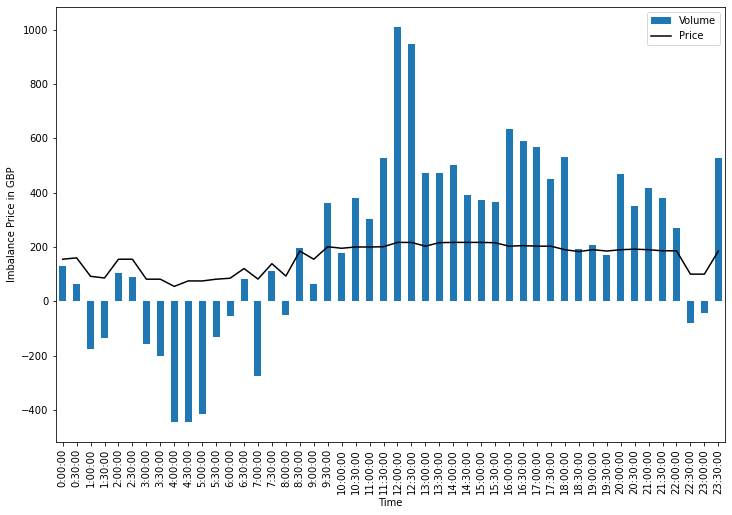

In [393]:
ax = dat_1770_1780.plot.bar(x='Time',y='Volume', ylabel='Imbalance Quantity in MwH', figsize=(12, 8))
dat_1770_1780.plot(y='Price', c='k', ax=ax, use_index=False, secondary_y=False, mark_right=False)
ax.set_ylabel('Imbalance Price in GBP')
ax.tick_params(axis='x', labelrotation = 90)

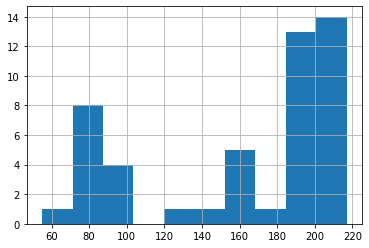

In [341]:
hist = dat_1770_1780['Price'].hist(bins=10)

In [372]:
print("%.3f" % dat_1770_1780['Volume'].corr(dat_1770_1780['Price']))

0.896


# The Total Daily Cost & Average unit cost of previous day

In [343]:
if (dat_1770_1780['Volume'].sum()!=0):
    total_cost=(dat_1770_1780['Volume'] * dat_1770_1780['Price']).sum()
    avg=total_cost/dat_1770_1780['Volume'].sum()
else:
    raise ValueError('The average unit pricee is indeterminate')
print ('The total cost on', start_period, 'was', "%.2f" %total_cost ,'GBP')
print ('The average unit cost on', start_period, 'was', "%.2f" %avg ,'GBP/MwH')    

The total cost on 2022-06-05 was 2376229.95 GBP
The average unit cost on 2022-06-05 was 230.91 GBP/MwH


### The highest volume time start period

In [401]:
idx = find_high(dat_1780,sp,j=2)
print ('The highest volume started at:', dat_1770_1780['Time'][idx],)

The highest volume started at: 12:00:00


# Modules

### GET Price and Volume Modules

In [374]:
def get_B1770(
    api_version='v1',
    api_key='*',
    settlement_period=None,
    periods='*',
    service_type='xml',
    api_base_url = f"https://api.bmreports.com/BMRS/B1770/"
    
):
  
    for num in range(1, periods):
        endpoint = f"{api_base_url}{api_version}?APIKey={api_key}&SettlementDate={settlement_period}&Period={str(num)}&ServiceType={service_type}"
        r = requests.get(endpoint)
        df = parse_xml_response(r)
    
        if num==1:
            data=pd.DataFrame(df)
        else:
            data=data.append(df)   
    return(data)

In [375]:
def get_B1780(
    api_version='v1',
    api_key='*',
    settlement_period=None,
    periods='*',
    service_type='xml',
    api_base_url = f"https://api.bmreports.com/BMRS/B1780/"
    
):
  
    for num in range(1, periods):
        endpoint = f"{api_base_url}{api_version}?APIKey={api_key}&SettlementDate={settlement_period}&Period={str(num)}&ServiceType={service_type}"
        r = requests.get(endpoint)
        df = parse_xml_response(r)
    
        if num==1:
            data=pd.DataFrame(df)
        else:
            data=data.append(df)   
    return(data)

### Calculating nos of Settlement Periods every day taking into account Daylight

In [347]:
def daylight_saving(
    start_date: start_period, 
    end_date: end_period, 
    freq: str='30T', 
    tz: str='Europe/London'
):
    dt_rng = pd.date_range(start_date, end_date, freq=freq, tz=tz)

    SPs = list((2*(dt_rng.hour + dt_rng.minute/60) + 1).astype(int))
    dt_strs = list(dt_rng.strftime('%Y-%m-%d'))

    df_dates_SPs = pd.DataFrame({'date':dt_strs, 'SP':SPs}, index=dt_rng).astype(str)
    
    # Accounting for daylight saving changes
    clock_change_dt_idxs_dir = pd.Series(dt_rng).apply(lambda dt: dt.utcoffset().total_seconds()).diff().replace(0, np.nan).dropna()

    for dt_idx, dir_ in clock_change_dt_idxs_dir.items():
        dt = dt_rng[dt_idx].date()
        SPs = (1 + 2*(dt_rng[dt_rng.date==dt] - pd.to_datetime(dt).tz_localize('Europe/London')).total_seconds()/(60*60)).astype(int)
        
        df_dates_SPs.loc[df_dates_SPs.index.date==dt, 'SP'] = SPs
    
    return df_dates_SPs

### Parsing the XML Get Response

In [376]:
def parse_xml_response(r):
    r_dict = xmltodict.parse(r.text)

    status_check_response = check_status(r)
    if status_check_response is not None:
        return status_check_response

    capping_applied = check_capping(r)

    data_content = r_dict['response']['responseBody']['responseList']['item']

    if isinstance(data_content, list):
        df = expand_cols(pd.DataFrame(data_content))
    elif isinstance(data_content, OrderedDict) or isinstance(data_content, dict):
        df = pd.DataFrame(pd.Series(data_content)).T
    else:
        raise ValueError('The returned `data_content` must be one of: `list`, `dict`, or `OrderedDict`')

    return df

### Checking status of each GET query 

In [348]:
def check_status(r):
    r_metadata = xmltodict.parse(r.text)['response']['responseMetadata']
    
    if r_metadata['httpCode'] == '204':
        warn(f'Data request was succesful but no content was returned')
        return pd.DataFrame()
        
    elif r_metadata['httpCode'] != '200':
        raise RequestError(r_metadata['httpCode'], r_metadata['errorType'], r_metadata['description'])
        
    return None

### Checking for capping 

In [349]:
def check_capping(r):
    r_metadata = xmltodict.parse(r.text)['response']['responseMetadata']
    
    if 'cappingApplied' in r_metadata.keys():
        if r_metadata['cappingApplied'] == 'Yes':
            capping_applied = True
        else:
            capping_applied = False
    else:
        capping_applied = 'Could not be determined'
        
    return capping_applied

### Convert the XML to dataframe for Data 

In [ ]:
def expand_cols(df, cols_2_expand=[]):
    if df.size == 0:
        return df
    
    for col in cols_2_expand:
        new_df_cols = df[col].apply(pd.Series)

        df[new_df_cols.columns] = new_df_cols
        df = df.drop(columns=col)

    s_cols_2_expand = df.iloc[0].apply(type).isin([OrderedDict, dict, list, tuple])

    if s_cols_2_expand.sum() > 0:
        cols_2_expand = s_cols_2_expand[s_cols_2_expand].index
        df = expand_cols(df, cols_2_expand)

    return df

### Converting Settlement Periods to datetime and timeseries

In [ ]:
def time_series_conv(df,period,k):
    df['Time']=''
    for i in range (0, period-1):
        c = df.iloc[i, k].item()-1
        b = str(dt.timedelta(hours=0, minutes=30*c))
        df.iloc[i, -1]=b
    return(df)

In [400]:
def find_high (df, periods, j):
    df['crawler']=''
    for i in range (0, periods-1):
        if i%2!=0:
            df.iloc[i,-1]=abs(df.iloc[i,j])+abs(df.iloc[i-1,j])
        else:
            df.iloc[i,-1]=0.00
    df['crawler'] = df['crawler'].astype(str).astype(float)
    b=df['crawler'].argmax()-1
    return(b)